In [1]:
! nvidia-smi

Fri Jan 29 01:23:39 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
import copy
from PIL import Image
from IPython.display import display

import torch
from torch.optim import SGD
from torch.optim import Adam
from torchvision import models
from torch.autograd import Variable

from pathlib import Path
import pandas as pd
import numpy as np

In [3]:
 from google.colab import files
 from google.colab import drive

In [4]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [6]:
bees_vs_wasps_dataset_path=Path('/content/gdrive/MyDrive/kaggle_bee_vs_wasp/') 
df_labels = pd.read_csv(bees_vs_wasps_dataset_path/'labels.csv')
df_labels=df_labels.set_index('id')
df_labels[['path']] = df_labels[['path']].replace(to_replace= r'\\', value= r'/', regex=True)
df_labels.head(5)

,path,is_bee,is_wasp,is_otherinsect,is_other,photo_quality,is_validation,is_final_validation,label
id,,,,,,,,,
1,bee1/10007154554_026417cfd0_n.jpg,1,0,0,0,1,0,0,bee
2,bee1/10024864894_6dc54d4b34_n.jpg,1,0,0,0,1,0,1,bee
3,bee1/10092043833_7306dfd1f0_n.jpg,1,0,0,0,1,1,0,bee
4,bee1/1011948979_fc3637e779_w.jpg,1,0,0,0,1,0,1,bee
5,bee1/10128235063_dca17db76c_n.jpg,1,0,0,0,1,0,0,bee


In [7]:
def preprocess_image(pil_im, resize_im=True):
    """
        Processes image for CNNs
    Args:
        PIL_img (PIL_img): PIL Image or numpy array to process
        resize_im (bool): Resize to 224 or not
    returns:
        im_as_var (torch variable): Variable that contains processed float tensor
    """
    # mean and std list for channels (Imagenet)
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    #ensure or transform incoming image to PIL image
    if type(pil_im) != Image.Image:
        try:
            pil_im = Image.fromarray(pil_im)
        except Exception as e:
            print("could not transform PIL_img to a PIL Image object. Please check input.")

    # Resize image
    if resize_im:
        pil_im = pil_im.resize((224, 224), Image.ANTIALIAS)

    im_as_arr = np.float32(pil_im)
    im_as_arr = im_as_arr.transpose(2, 0, 1)  # Convert array to D,W,H
    # Normalize the channels
    for channel, _ in enumerate(im_as_arr):
        im_as_arr[channel] /= 255
        im_as_arr[channel] -= mean[channel]
        im_as_arr[channel] /= std[channel]
    # Convert to float tensor
    im_as_ten = torch.from_numpy(im_as_arr).float()
    # Add one more channel to the beginning. Tensor shape = 1,3,224,224
    im_as_ten.unsqueeze_(0)
    # Convert to Pytorch variable
    im_as_var = Variable(im_as_ten, requires_grad=True)
    return im_as_var

In [8]:
def recreate_image(im_as_var):
    """
        Recreates images from a torch variable, sort of reverse preprocessing
    Args:
        im_as_var (torch variable): Image to recreate
    returns:
        recreated_im (numpy arr): Recreated image in array
    """
    reverse_mean = [-0.485, -0.456, -0.406]
    reverse_std = [1/0.229, 1/0.224, 1/0.225]
    recreated_im = copy.copy(im_as_var.data.numpy()[0])
    for c in range(3):
        recreated_im[c] /= reverse_std[c]
        recreated_im[c] -= reverse_mean[c]
    recreated_im[recreated_im > 1] = 1
    recreated_im[recreated_im < 0] = 0
    recreated_im = np.round(recreated_im * 255)

    recreated_im = np.uint8(recreated_im).transpose(1, 2, 0)
    return recreated_im

In [9]:
def format_np_output(np_arr):
    """
        This is a (kind of) bandaid fix to streamline saving procedure.
        It converts all the outputs to the same format which is 3xWxH
        with using sucecssive if clauses.
    Args:
        im_as_arr (Numpy array): Matrix of shape 1xWxH or WxH or 3xWxH
    """
    # Phase/Case 1: The np arr only has 2 dimensions
    # Result: Add a dimension at the beginning
    if len(np_arr.shape) == 2:
        np_arr = np.expand_dims(np_arr, axis=0)
    # Phase/Case 2: Np arr has only 1 channel (assuming first dim is channel)
    # Result: Repeat first channel and convert 1xWxH to 3xWxH
    if np_arr.shape[0] == 1:
        np_arr = np.repeat(np_arr, 3, axis=0)
    # Phase/Case 3: Np arr is of shape 3xWxH
    # Result: Convert it to WxHx3 in order to make it saveable by PIL
    if np_arr.shape[0] == 3:
        np_arr = np_arr.transpose(1, 2, 0)
    # Phase/Case 4: NP arr is normalized between 0-1
    # Result: Multiply with 255 and change type to make it saveable by PIL
    if np.max(np_arr) <= 1:
        np_arr = (np_arr*255).astype(np.uint8)
    return np_arr

In [10]:
def display_image(im):

    if isinstance(im, (np.ndarray, np.generic)):
        im = format_np_output(im)
        im = Image.fromarray(im)
    display(im)


In [11]:
def save_image(im, size, path):
    """
        Saves a numpy matrix or PIL image as an image
    Args:
        im_as_arr (Numpy array): Matrix of shape DxWxH
        path (str): Path to the image
    """
    if isinstance(im, (np.ndarray, np.generic)):
        im = format_np_output(im)
        im = Image.fromarray(im)
    im = im.resize(size, Image.ANTIALIAS)
    im.save(path)

In [12]:
class DeepDream():

  def __init__(self, model, layer_name, selected_filter, im_path, iter, l_rate):
      self.model = model
      self.selected_layer = layer_name
      self.selected_filter = selected_filter
      self.handle = 0
      self.conv_output = 0
      self.iterations = iter
      self.lr = l_rate
      self.created_image = Image.open(im_path).convert('RGB')
      self.original_size =  self.created_image.size[0:2]
      self.hook_layer_resnet()

  #Resnet_hook
  def save_output(self, model, input, output):
    self.conv_output = output[0][self.selected_filter]

  def hook_layer_resnet(self):
    for name, layer in self.model.named_modules():
      if name == self.selected_layer:
        if isinstance(layer, torch.nn.modules.conv.Conv2d):
          self.handle = layer.register_forward_hook(self.save_output)

  def dream(self):
    self.processed_image = preprocess_image(self.created_image, True)
    #optimizer = SGD([self.processed_image], lr=self.lr)
    optimizer = Adam([self.processed_image], lr=self.lr)
    
    for i in range(1, self.iterations+1):
        optimizer.zero_grad()     
        x = self.processed_image
        output = self.model(x)       
        loss = -torch.mean(self.conv_output)
        
        print('Iteration:', str(i), 'Loss:', "{0:.2f}".format(loss.data.numpy()))
       
        # Backward
        loss.backward()
        # Update image
        optimizer.step()
        # Recreate image
        self.created_image = recreate_image(self.processed_image)

        if i % 10 == 0:
            print(self.created_image.shape)
            im_path = '/content/gdrive/MyDrive/DeepDream/' + str(self.selected_layer) + '_f' + str(self.selected_filter) + '_iter' + str(i) + '.jpg'
            save_image(self.created_image, self.original_size, im_path)


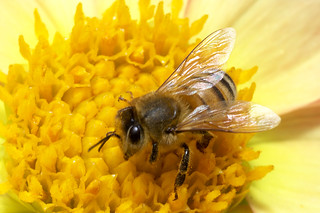

(320, 213)

In [13]:
img1 = 'bee1/1376862575_71d55ca527_n.jpg'
img2 = 'bee1/52033120_49a69b55c0_n.jpg'
img_path = '/content/gdrive/MyDrive/kaggle_bee_vs_wasp/' + img1
image = Image.open(img_path)
display(image)
image.size[0:2]


In [15]:
filter_pos = 34
# layer_name = "layer3.5.conv3"
layer_name = "layer4.2.conv2"
# pretrained_model = models.vgg19(pretrained=True).features
pretrained_model = models.resnet50(pretrained=True)
dd = DeepDream(pretrained_model, layer_name, filter_pos, img_path, 130, 0.1)
dd.dream()

Iteration: 1 Loss: 0.08
Iteration: 2 Loss: 0.06
Iteration: 3 Loss: 0.03
Iteration: 4 Loss: 0.00
Iteration: 5 Loss: -0.02
Iteration: 6 Loss: -0.05
Iteration: 7 Loss: -0.08
Iteration: 8 Loss: -0.10
Iteration: 9 Loss: -0.12
Iteration: 10 Loss: -0.14
(224, 224, 3)
Iteration: 11 Loss: -0.15
Iteration: 12 Loss: -0.16
Iteration: 13 Loss: -0.17
Iteration: 14 Loss: -0.18
Iteration: 15 Loss: -0.20
Iteration: 16 Loss: -0.20
Iteration: 17 Loss: -0.22
Iteration: 18 Loss: -0.23
Iteration: 19 Loss: -0.24
Iteration: 20 Loss: -0.25
(224, 224, 3)
Iteration: 21 Loss: -0.25
Iteration: 22 Loss: -0.26
Iteration: 23 Loss: -0.26
Iteration: 24 Loss: -0.27
Iteration: 25 Loss: -0.27
Iteration: 26 Loss: -0.28
Iteration: 27 Loss: -0.29
Iteration: 28 Loss: -0.29
Iteration: 29 Loss: -0.30
Iteration: 30 Loss: -0.30
(224, 224, 3)
Iteration: 31 Loss: -0.30
Iteration: 32 Loss: -0.31
Iteration: 33 Loss: -0.32
Iteration: 34 Loss: -0.32
Iteration: 35 Loss: -0.32
Iteration: 36 Loss: -0.33
Iteration: 37 Loss: -0.33
Iteration